In [1]:
import sys

sys.path.append("../")


from time_series_parser import *
import polars as pl
import matplotlib.pyplot as plt

In [2]:
df = parse_fit_file(
    "/home/sayantan/Downloads/First_buttery_of_the_year_with_the_gang.fit"
)

In [5]:
df.columns

['timestamp (None)',
 'position_lat (semicircles)',
 'position_long (semicircles)',
 'distance (m)',
 'enhanced_speed (m/s)',
 'enhanced_altitude (m)',
 'power (watts)',
 'heart_rate (bpm)',
 'temperature (C)',
 'unknown_107 (None)',
 'unknown_134 (None)',
 'unknown_137 (None)',
 'unknown_138 (None)',
 'unknown_144 (None)',
 'unknown_108 (None)',
 'accumulated_power (watts)',
 'cadence (rpm)',
 'fractional_cadence (rpm)',
 'unknown_90 (None)']

In [28]:
f_moving = pl.col("^.*speed.*$") >= 1.5

df.filter(f_moving).describe().select(
    pl.col("statistic"),
    pl.col("power (watts)"),
    (pl.col("^.*speed.*$") * 3.6).alias("Speed (km/h)"),
)

statistic,power (watts),Speed (km/h)
str,f64,f64
"""count""",10712.0,38631.6
"""null_count""",19.0,0.0
"""mean""",153.434746,23.871919
"""std""",119.63022,7.413291
"""min""",0.0,5.4072
"""25%""",44.0,18.9792
"""50%""",153.0,22.9752
"""75%""",240.0,28.35
"""max""",696.0,53.8452


In [40]:
df_filtered = df.filter(f_moving).with_columns(
    pl.col("power (watts)")
    .cut(
        [
            0,
            140,
            191,
            229,
            # 268,
            # 306,
            # 382,
            # 1000,
        ],
        left_closed=True,
    )
    .alias("Power bucket"),
    (pl.col("^.*speed.*$") * 3.6).rolling_mean(10).alias("Speed (km/h)"),
    pl.col("power (watts)")
    .fill_null(strategy="forward")
    .rolling_mean(10)
    .alias("10s Power"),
)

In [41]:
df_filtered.select(pl.col("^.*((P|p)ower|Speed).*$"))

power (watts),accumulated_power (watts),Power bucket,Speed (km/h),10s Power
i64,i64,cat,f64,f64
null,null,null,null,null
0,null,"""[0, 140)""",null,null
0,null,"""[0, 140)""",null,null
0,null,"""[0, 140)""",null,null
0,null,"""[0, 140)""",null,null
…,…,…,…,…
0,1650828,"""[0, 140)""",10.72548,50.7
0,1650828,"""[0, 140)""",10.47672,29.8
0,1650828,"""[0, 140)""",10.15452,8.9


In [42]:
df_filtered.group_by(pl.col("Power bucket")).len().with_columns(
    (pl.col("len") / df.shape[0] * 100).alias("Fraction")
)

Power bucket,len,Fraction
cat,u32,f64
null,19,0.175099
"""[229, inf)""",2987,27.527417
"""[0, 140)""",4990,45.986545
"""[191, 229)""",1140,10.505944
"""[140, 191)""",1595,14.699106


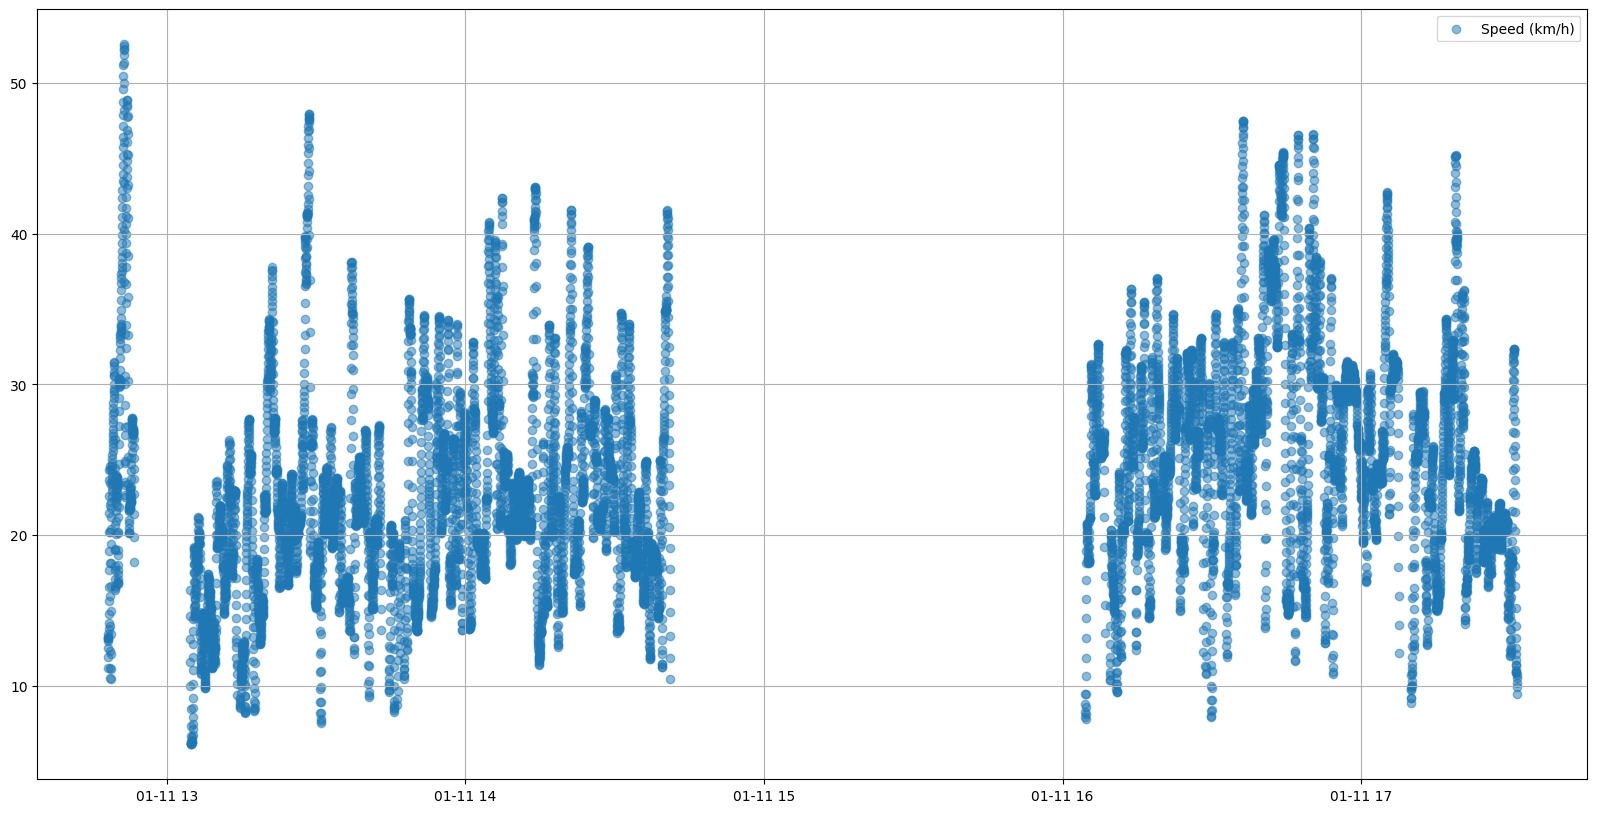

In [43]:
plt.figure(figsize=(20, 10))

# plt.scatter(
#     df_filtered["timestamp (None)"],
#     df_filtered["10s Power"],
#     alpha=0.5,
#     label="10s Power",
# )

plt.scatter(
    df_filtered["timestamp (None)"],
    df_filtered["Speed (km/h)"],
    alpha=0.5,
    label="Speed (km/h)",
)

plt.legend()
plt.grid()